# Python version - Supermodel 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [3]:
def dNdt(H, P, PH, N, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    m_H = parameters_dict['m_H'] # Herbivore mortality 
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    m_P = parameters_dict['m_P'] # Predator mortality
    #Unpacking phytoplankton and nutrients parameters: 
    v_m = parameters_dict['v_m'] # max growth rate of phytoplankton
    k_s = parameters_dict['k_s'] # half saturation constant
    m_ph = parameters_dict['m_ph'] # phytoplankton mortality 
    y = parameters_dict['y'] # unassimilated phytoplankton 
    #Unpacking grazing parameters: 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    #more timesteps
    #dt = parameters_dict['dt']
    
    #Calculate the derivative 
    #grazing_t1 = r_m * (kg**-1 * PH * (1 - math.exp(-kg**-1 * PH))) * H
    
    #dH = ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dH = r_H*H*(1-H/K_H) + ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - (m_H*H)
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P - m_P * P 
    dPH = ((v_m * N * PH)/(k_s + N)) - (m_ph * PH) - ((r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H)
    dN = -(PH * (v_m * N) / (k_s + N)) + (0.5 * m_ph * PH) + (0.5 * m_H * H) + (1 * y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                0.5 * m_P * P)
    return dH, dP, dPH, dN

In [4]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0 
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [5]:
# Function to run the model 

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

# Test

In [6]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 50 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.4/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.1/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.1/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.4/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = 0.03 # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }


In [7]:
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

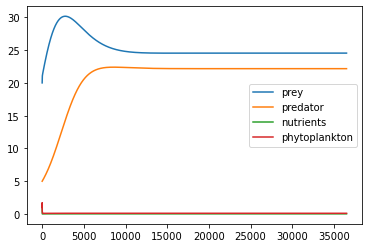

In [8]:
annual_time = (numyears)/365

plt.plot(H_array, label="prey")
plt.plot(P_array, label="predator")
plt.plot(N_array, label="nutrients")
plt.plot(PH_array, label="phytoplankton")
#plt.xticks(range(0, int(annual_time)+1, 10))
plt.legend()

### from days to years

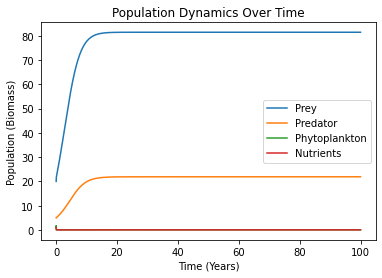

In [8]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label="Predator")
plt.plot(time_years, PH_array, label="Phytoplankton")
plt.plot(time_years, N_array, label="Nutrients")

plt.xlabel("Time (Years)")
plt.ylabel("Population (Biomass)")
plt.title("Population Dynamics Over Time")
plt.legend()

plt.savefig("figs/time_series_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

In [9]:
print(N_array[-1])
print(PH_array[-1])
print(H_array[-1])
print(P_array[-1])

0.029798187530967853
0.06740120833608981
93.23991315028523
12.754676405983927


# Function to reset to Default Params

In [24]:
def default_params():
    numyears = 36500 # number of years to run simulation 

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 100 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.4/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = 0.0 # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.2/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.4/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = 0.0 # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = (0.03) # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }
    
    return parameters_dict

## Fishing Scenarios

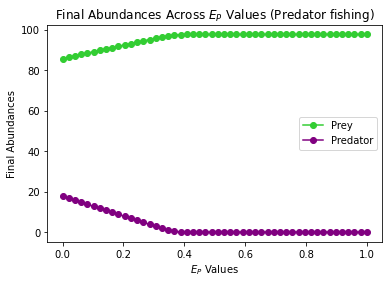

In [45]:
parameters_dict = default_params()

# Define the range of E_P values to plot
size = 50
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-25:-1])
    P_final_array[i] = np.mean(P_array[-25:-1])

# Plot the final abundances
plt.plot(E_P_array, H_final_array, label='Prey', color="limegreen", marker="o")
plt.plot(E_P_array, P_final_array, label='Predator', color="purple", marker="o")
plt.title('Final Abundances Across $E_P$ Values (Predator fishing)')
plt.xlabel('$E_P$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

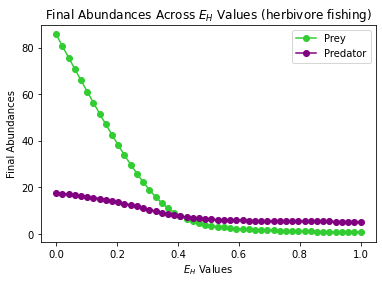

In [46]:
parameters_dict = default_params()

# Define the range of E_H values to plot
size = 50
E_H_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, E_H in enumerate(E_H_array):
    parameters_dict['E_H'] = E_H/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-25:-1])
    P_final_array[i] = np.mean(P_array[-25:-1])

# Plot the final abundances
plt.plot(E_H_array, H_final_array, label='Prey', color="limegreen", marker ="o")
plt.plot(E_H_array, P_final_array, label='Predator', color="purple", marker="o")
plt.title('Final Abundances Across $E_H$ Values (herbivore fishing)')
plt.xlabel('$E_H$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

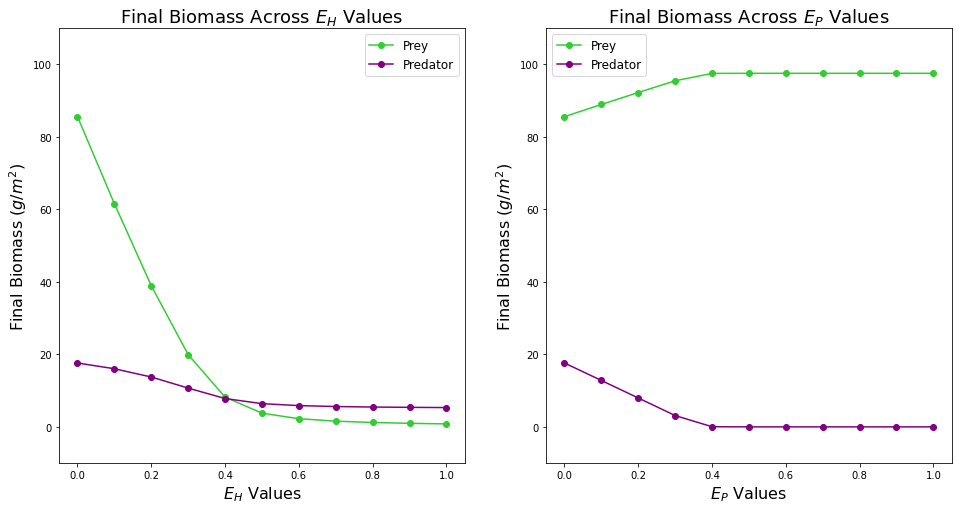

In [47]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

parameters_dict = default_params()

# Define the range of E_H values to plot
size = 11
E_H_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

# Prey fishing effort 
for i, E_H in enumerate(E_H_array):
    parameters_dict['E_H'] = E_H/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    
ax1.plot(E_H_array, H_final_array, label='Prey', color="limegreen", marker="o")
ax1.plot(E_H_array, P_final_array, label='Predator', color="purple", marker="o")
ax1.set_title('Final Biomass Across $E_H$ Values', fontsize=18)
ax1.set_xlabel('$E_H$ Values', fontsize=16)
ax1.set_ylabel('Final Biomass ($g/m^2$)', fontsize=16)
ax1.set_ylim(-10,110)
ax1.legend(fontsize=12)
    
parameters_dict = default_params()

# Define the range of E_P values to plot
size = 11
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    

ax2.plot(E_P_array, H_final_array, label='Prey', color="limegreen", marker ="o")
ax2.plot(E_P_array, P_final_array, label='Predator', color="purple", marker ="o")
ax2.set_title('Final Biomass Across $E_P$ Values', fontsize=18)
ax2.set_xlabel('$E_P$ Values', fontsize=16)
ax2.set_ylabel('Final Biomass ($g/m^2$)', fontsize=16)
ax2.set_ylim(-10,110)
ax2.legend(fontsize=12)

plt.savefig("figs/fishing_biomass.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

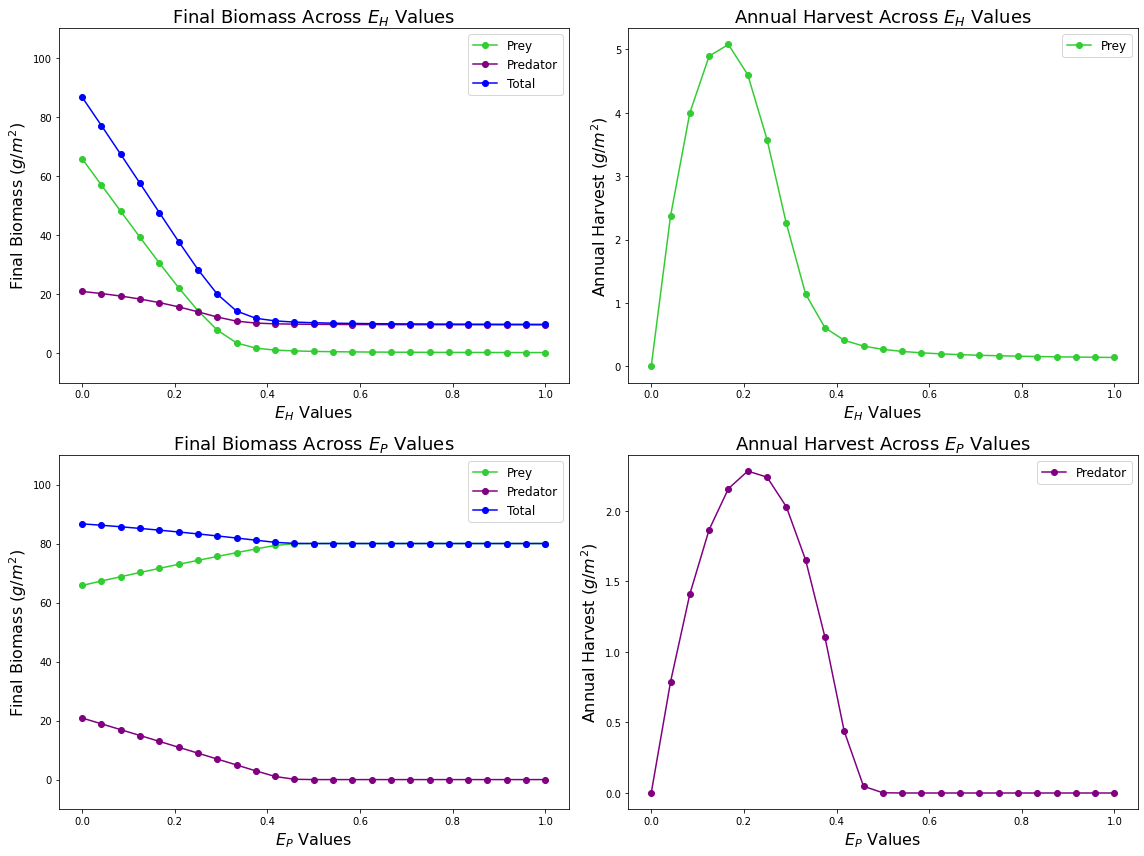

In [25]:
# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

parameters_dict = default_params()

# Define the range of E_H values to plot
size = 25
E_H_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)
T_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)

# Prey fishing effort 
for i, E_H in enumerate(E_H_array):
    parameters_dict['E_H'] = E_H/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    H_harvest_final_array[i] = np.mean(H_harvest_array[-3650:-1])
    P_harvest_final_array[i] = np.mean(P_harvest_array[-3650:-1])
    # Add to get total abundance
    T_final_array = np.add(H_final_array, P_final_array)
    
ax1.plot(E_H_array, H_final_array, label='Prey', color="limegreen", marker="o")
ax1.plot(E_H_array, P_final_array, label='Predator', color="purple", marker="o")
ax1.plot(E_H_array, T_final_array, label='Total', color="blue", marker="o")
ax1.set_title('Final Biomass Across $E_H$ Values', fontsize=18)
ax1.set_xlabel('$E_H$ Values', fontsize=16)
ax1.set_ylabel('Final Biomass ($g/m^2$)', fontsize=16)
ax1.set_ylim(-10,110)
ax1.legend(fontsize=12)

H_annual_harvest = 365*H_harvest_final_array

ax2.plot(E_H_array, H_annual_harvest, label='Prey', color="limegreen", marker="o")
ax2.set_title('Annual Harvest Across $E_H$ Values', fontsize=18)
ax2.set_xlabel('$E_H$ Values', fontsize=16)
ax2.set_ylabel('Annual Harvest ($g/m^2$)', fontsize=16)
ax2.legend(fontsize=12)

    
parameters_dict = default_params()

# Define the range of E_P values to plot
size = 25
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)
T_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    H_harvest_final_array[i] = np.mean(H_harvest_array[-3650:-1])
    P_harvest_final_array[i] = np.mean(P_harvest_array[-3650:-1])
    # Add to get total abundance
    T_final_array = np.add(H_final_array, P_final_array)
    

ax3.plot(E_P_array, H_final_array, label='Prey', color="limegreen", marker ="o")
ax3.plot(E_P_array, P_final_array, label='Predator', color="purple", marker ="o")
ax3.plot(E_P_array, T_final_array, label='Total', color="blue", marker ="o")
ax3.set_title('Final Biomass Across $E_P$ Values', fontsize=18)
ax3.set_xlabel('$E_P$ Values', fontsize=16)
ax3.set_ylabel('Final Biomass ($g/m^2$)', fontsize=16)
ax3.set_ylim(-10,110)
ax3.legend(fontsize=12)

P_annual_harvest = 365*P_harvest_final_array

ax4.plot(E_P_array, P_annual_harvest, label='Predator', color="purple", marker ="o")
ax4.set_title('Annual Harvest Across $E_P$ Values', fontsize=18)
ax4.set_xlabel('$E_P$ Values', fontsize=16)
ax4.set_ylabel('Annual Harvest ($g/m^2$)', fontsize=16)
ax4.legend(fontsize=12)

plt.savefig("figs/fishing_four_panel.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
            
plt.tight_layout()
plt.show()

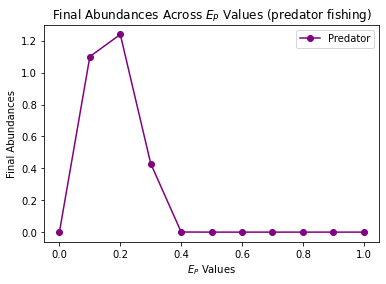

In [27]:
parameters_dict = default_params()

# Define the range of E_H values to plot
size = 11
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    H_harvest_final_array[i] = np.mean(H_harvest_array[-3650:-1])
    P_harvest_final_array[i] = np.mean(P_harvest_array[-3650:-1])

    
annual_harvest = 365*P_harvest_final_array

# Plot the final abundances
plt.plot(E_P_array, annual_harvest, label='Predator', color="purple", marker ="o")
plt.title('Final Abundances Across $E_P$ Values (predator fishing)')
plt.xlabel('$E_P$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

In [48]:
annual_harvest

array([0.00000000e+00, 1.71087916e+00, 2.46073745e+00, 2.24404047e+00,
       1.05625558e+00, 8.06760734e-03, 1.26112262e-06, 1.46040377e-10,
       1.64850705e-14, 1.87553893e-18, 2.16046375e-22])

In [49]:
  def default_params():
    numyears = 36500 # number of years to run simulation 

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 100 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.4/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = 0.0 # Effort for herbivore harvest
    m_H = (0.01/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.2/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.4/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = 0.0 # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality
    
    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = (0.01) # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }
    
    return parameters_dict

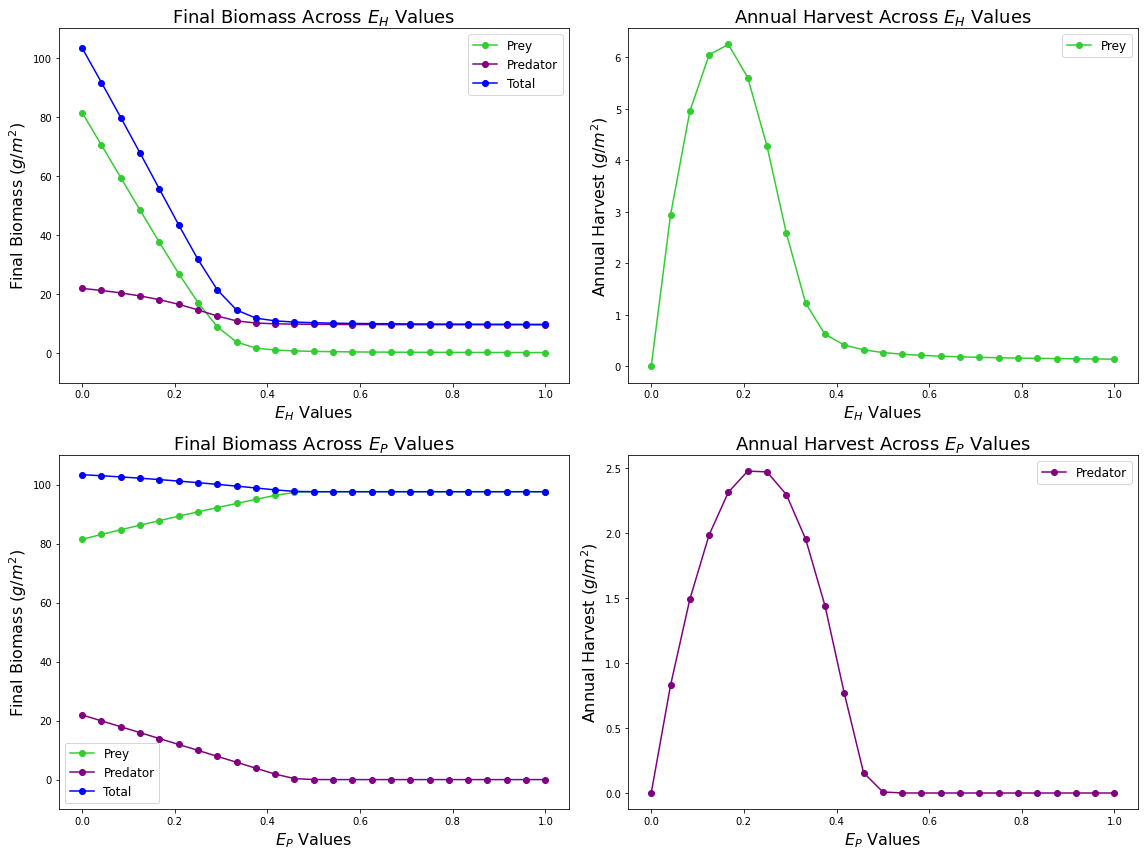

In [50]:
# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

parameters_dict = default_params()

# Define the range of E_H values to plot
size = 25
E_H_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)
T_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)

# Prey fishing effort 
for i, E_H in enumerate(E_H_array):
    parameters_dict['E_H'] = E_H/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    H_harvest_final_array[i] = np.mean(H_harvest_array[-3650:-1])
    P_harvest_final_array[i] = np.mean(P_harvest_array[-3650:-1])
    # Add to get total abundance
    T_final_array = np.add(H_final_array, P_final_array)
    
ax1.plot(E_H_array, H_final_array, label='Prey', color="limegreen", marker="o")
ax1.plot(E_H_array, P_final_array, label='Predator', color="purple", marker="o")
ax1.plot(E_H_array, T_final_array, label='Total', color="blue", marker="o")
ax1.set_title('Final Biomass Across $E_H$ Values', fontsize=18)
ax1.set_xlabel('$E_H$ Values', fontsize=16)
ax1.set_ylabel('Final Biomass ($g/m^2$)', fontsize=16)
ax1.set_ylim(-10,110)
ax1.legend(fontsize=12)

H_annual_harvest = 365*H_harvest_final_array

ax2.plot(E_H_array, H_annual_harvest, label='Prey', color="limegreen", marker="o")
ax2.set_title('Annual Harvest Across $E_H$ Values', fontsize=18)
ax2.set_xlabel('$E_H$ Values', fontsize=16)
ax2.set_ylabel('Annual Harvest ($g/m^2$)', fontsize=16)
ax2.legend(fontsize=12)

    
parameters_dict = default_params()

# Define the range of E_P values to plot
size = 25
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)
T_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])
    H_harvest_final_array[i] = np.mean(H_harvest_array[-3650:-1])
    P_harvest_final_array[i] = np.mean(P_harvest_array[-3650:-1])
    # Add to get total abundance
    T_final_array = np.add(H_final_array, P_final_array)
    

ax3.plot(E_P_array, H_final_array, label='Prey', color="limegreen", marker ="o")
ax3.plot(E_P_array, P_final_array, label='Predator', color="purple", marker ="o")
ax3.plot(E_P_array, T_final_array, label='Total', color="blue", marker ="o")
ax3.set_title('Final Biomass Across $E_P$ Values', fontsize=18)
ax3.set_xlabel('$E_P$ Values', fontsize=16)
ax3.set_ylabel('Final Biomass ($g/m^2$)', fontsize=16)
ax3.set_ylim(-10,110)
ax3.legend(fontsize=12)

P_annual_harvest = 365*P_harvest_final_array

ax4.plot(E_P_array, P_annual_harvest, label='Predator', color="purple", marker ="o")
ax4.set_title('Annual Harvest Across $E_P$ Values', fontsize=18)
ax4.set_xlabel('$E_P$ Values', fontsize=16)
ax4.set_ylabel('Annual Harvest ($g/m^2$)', fontsize=16)
ax4.legend(fontsize=12)

plt.savefig("figs/fishing_four_panel.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
            
plt.tight_layout()
plt.show()

# Heatmaps ?

In [25]:
parameters_dict = default_params()

size = 10
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

#Loop through E_P and E_H values from 0-1 
for i in np.arange(0, size):
    for j in np.arange(0, size):
        E_H = E_H_array[i]
        E_P = E_P_array[j] 
        parameters_dict['E_H'] = E_H 
        parameters_dict['E_P'] = E_P
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_last = np.mean(H_array[-25:-1])
        P_last = np.mean(P_array[-25:-1])
        T_last = np.mean(np.add(H_array[-25:-1], P_array[-25:-1]))
        heatmap_T[i,j] = T_last
        heatmap_H[i,j] = H_last
        heatmap_P[i,j] = P_last
        j+=1
    i+=1

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-pa